<a href="https://colab.research.google.com/github/Ja1Denis/TraLeImCl/blob/master/Homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework

The homework for this week is to build 3 different types of regression lines to predict stock prices using Python, then print out the prediction for the best performing one.

#Step 1 -
Go to Yahoo Finance and find a stock price that you want to predict. Click on historical data, then download the CSV of that stocks price history https://finance.yahoo.com/quote/AAPL/history?p=AAPL  

#Step 2 -
Use Scikit learn to try out 3 different types of regression models to predict the price of that stock for a future date. See this https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7  as an example and the scikit learn docs to see all the different types of regression models you can easily build (i.e quadratic, linear, lasso, ridge, etc.)

#Step 3 -
Visualize your result using matplotlib or another plotting library of your choice

Once your code is complete, upload it to GitHub and send the github link to gradedhomeworkassignments@gmail.com with your full name as the subject line.  Good luck!

In [0]:
#import necesary packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

# Download the data and store it
#  Google stock since the beginning


In [0]:
!wget -O GOOG.csv https://www.dropbox.com/s/yzg0m5ok030bmuo/GOOG.csv?dl=0

--2019-09-05 08:55:41--  https://www.dropbox.com/s/yzg0m5ok030bmuo/GOOG.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/yzg0m5ok030bmuo/GOOG.csv [following]
--2019-09-05 08:55:42--  https://www.dropbox.com/s/raw/yzg0m5ok030bmuo/GOOG.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc708d73676ee9ddc27334478d74.dl.dropboxusercontent.com/cd/0/inline/An-0HfcolWzXa2z8W-8izAdrgPjeeNJ3Ac1FRVU7wk-NrIAHCEZ4ZUO5axJFQB_4UwuRCHqQP4yAUUm7wi3F3W5ZdT39P7snljO5lkT6AkCwmxc2jLsBPp-z-NgHSCdbGOg/file# [following]
--2019-09-05 08:55:42--  https://uc708d73676ee9ddc27334478d74.dl.dropboxusercontent.com/cd/0/inline/An-0HfcolWzXa2z8W-8izAdrgPjeeNJ3Ac1FRVU7wk-NrIAHCEZ4ZUO5axJFQB_4UwuRCHqQP4yAUUm7wi3F3W5ZdT39P7snljO5lkT6AkCwmxc2jLsBPp

Use Pandas to read in the data and set the independent variable to be the *Date* andalso take a look at the first few entries.

In [0]:
df = pd.read_csv('GOOG.csv')

In [0]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-04,1204.270020,1212.989990,1192.500000,1197.000000,1197.000000,1831000
2018-09-05,1193.800049,1199.010010,1162.000000,1186.479980,1186.479980,2061300
2018-09-06,1186.300049,1186.300049,1152.000000,1171.439941,1171.439941,1888500
2018-09-07,1158.670044,1175.260010,1157.214966,1164.829956,1164.829956,1401300
2018-09-10,1172.189941,1174.540039,1160.109985,1164.640015,1164.640015,1115400


Let's take a look at how the prices looks like each day since the beginning up to this point with the date on the x-axis and the price on the y-axis.

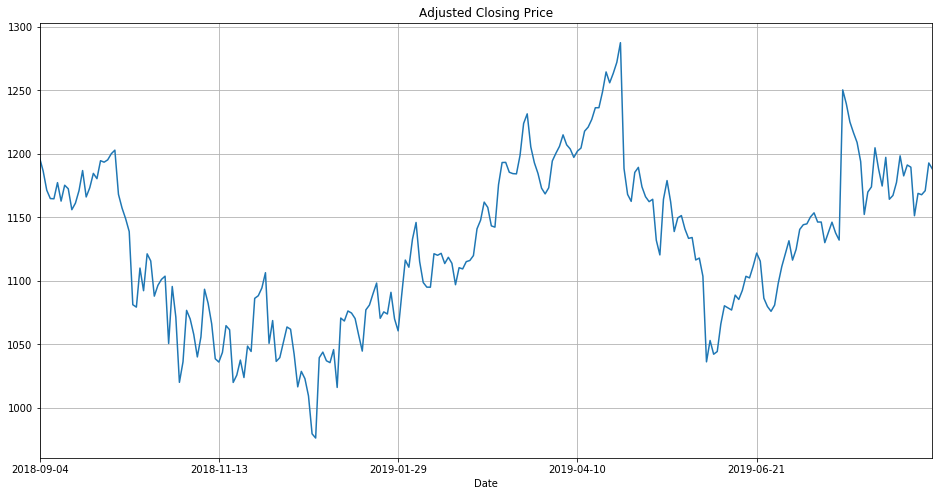

In [0]:
df['Adj Close'].plot(label='GOOG', figsize=(16,8), title='Adjusted Closing Price', grid=True)

To make this more robust to noise and to leverage past values, we will not use the date to predict the stock prices, but we will use batches of 32 prices where each training example, we leverage 32 prices from the past to predict the price on the 33rd day.  We will thus have $N - 32$ training examples with $N$ being the number of days we've downloaded for the stock data.  We will thus create a 2D matrix of training samples with each row being the prices 32 consecutive days in the past with the price to predict being the current day.

In [0]:
window_size = 32 # Allow us to look at 32 days into the past
# Prepare the data so that we have 32 day windows and predict what the next day should be

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [0]:
data = df['Adj Close'].values[indices] # Create the 2D matrix of training samples

We create a 2D matrix such that we have 33 columns per example.  The training samples will be the first 32 columns with the target variable being the last column.

In [0]:
X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1] # Each output value represents the 33rd day

Perform train/test split such that the first 80% of the prices is the training set and the last 20% of the prices is the test dataset.  We will train on the training set and test the performance on the test set to see how well we can forecast the price for Tesla stock.

In [0]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

# Method #1 - Ridge Regression

We will use the Ridge Regression method from Scikit-learn where we'll train and perform inference on the training and test data respectively.  Let's also plot how it compares with the actual data for both training and test.

In [0]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

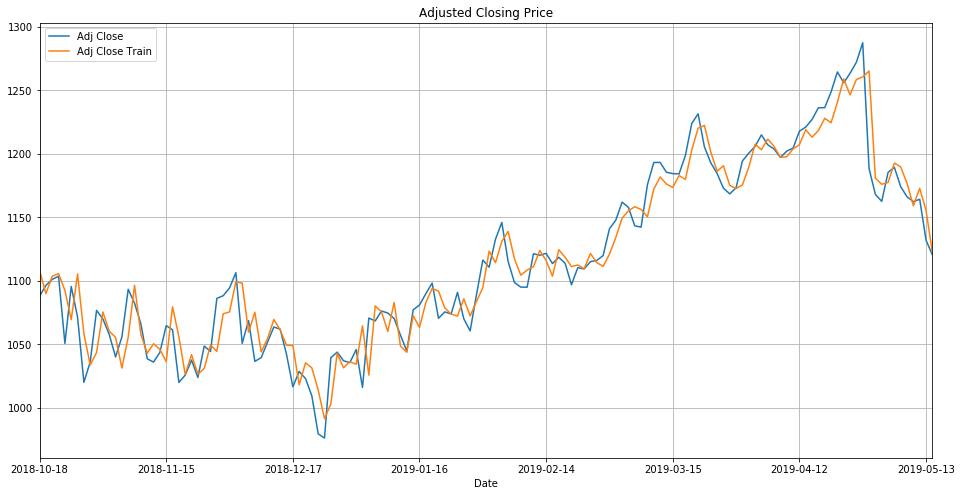

In [0]:
# Plot what it looks like for the training data
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label='GOOG', figsize=(16,8), title='Adjusted Closing Price', grid=True)

 Let's check out the test data.
 

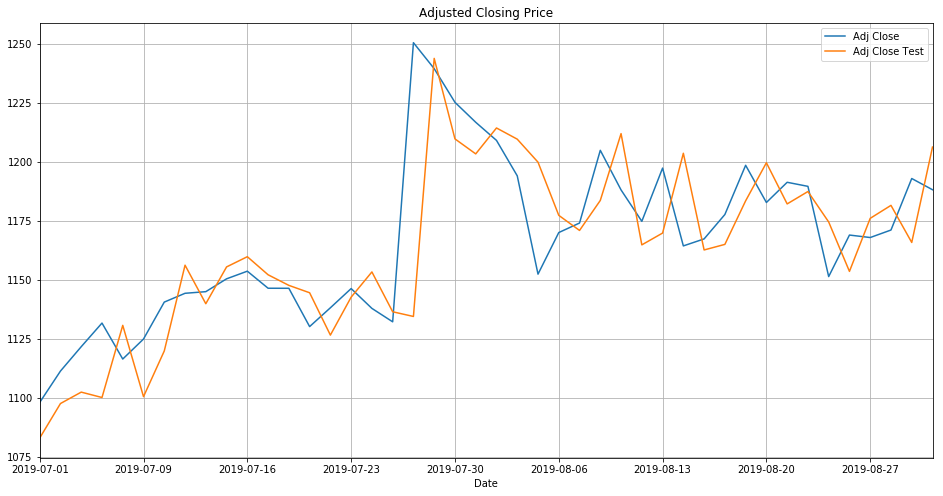

In [0]:
# Same for the test
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='GOOG', figsize=(16,8), title='Adjusted Closing Price', grid=True)

Wow... ok let's move on.

# Method #2 - Gradient Boosting Trees

Let's apply the same methodology from Method #1 to Gradient Boosting Trees in Scikit-learn.

In [0]:
# Model #2 - Gradient Boosting Trees
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)


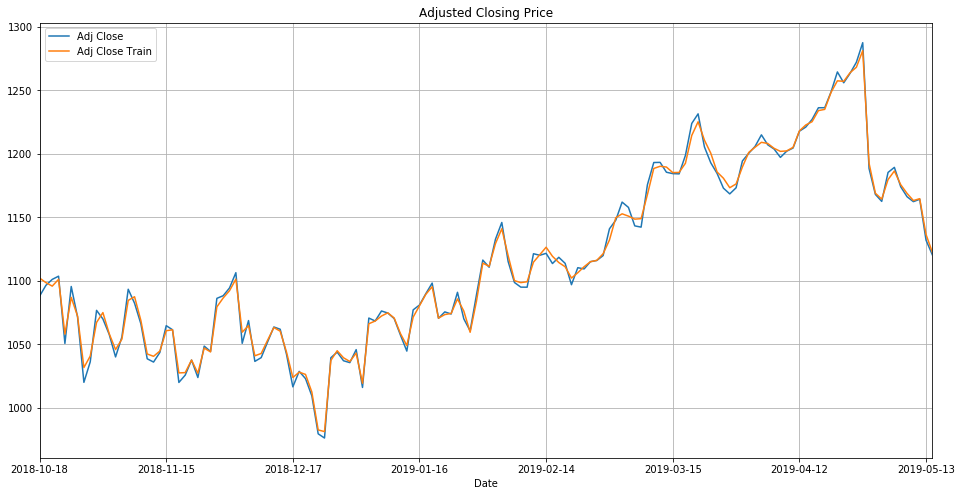

In [0]:
# Plot what it looks like for the training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='GOOG', figsize=(16,8), title='Adjusted Closing Price', grid=True)

Again... frighteningly similar.  Let's check the test data.

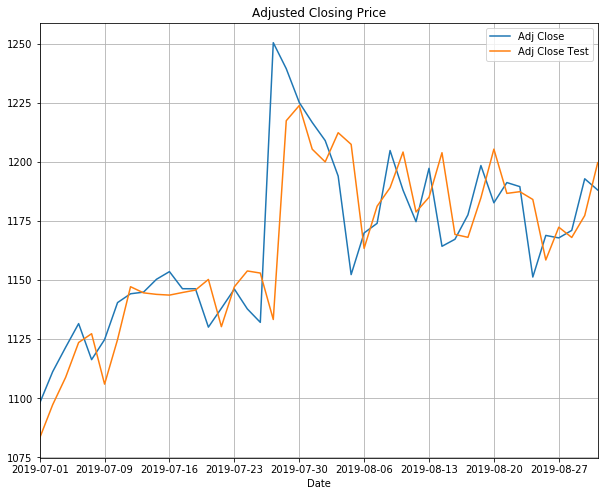

In [0]:
# Same for the test
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='GOOG', figsize=(10,8), title='Adjusted Closing Price', grid=True)

The results here make sense.  Since trees performing majority voting so there's no interpolation involved, we can see at points of high curvature, it doesn't do so well but the general trend is correct.

# Method #3 - Using neural networks with 1D convolutional and LSTM layers

The last method we'll use is a neural network based one using Keras / Tensorflow.  We use a stack of Conv1D and LSTM layers, followed by Dense layers lastly followed by a linear layer to predict the stock price.

In [0]:
# Model #3 - Using RNNs
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

keras_model.summary()

W0905 09:15:52.487386 140081875003264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0905 09:15:52.550544 140081875003264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0905 09:15:52.558501 140081875003264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 32, 128)           768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           82048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

This is a technique to find the optimal learning rate for the neural network.  Specifically we gradually increase the learning rate at each epoch, recording the loss for each then choosing the learning rate that has the smallest loss overall.

Also, neural networks learn better when the data is normalized so we will normalize the data to the $[-1,1]$ range by using Scikit-learn's `MinMaxScaler`.  Therefore, we need to find apply this scaling on all of the price data, then decompose it into the training and test sets again.

In [0]:
# First figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]
X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]

W0905 09:16:55.237554 140081875003264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



We now try and find the optimal learning rate.  If you're using Google Colab, this will take ~4 minutes.

In [0]:
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, y_test_reshape))

W0905 09:17:42.243021 140081875003264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0905 09:17:43.820538 140081875003264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0905 09:17:43.893925 140081875003264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 174 samples, validate on 44 samples
Epoch 1/250
174/174 [==============================] - 8s 47ms/step - loss: 0.0937 - mean_absolute_error: 0.3715 - val_loss: 0.0488 - val_mean_absolute_error: 0.2499
Epoch 2/250
174/174 [==============================] - 0s 1ms/step - loss: 0.0937 - mean_absolute_error: 0.3715 - val_loss: 0.0488 - val_mean_absolute_error: 0.2499
Epoch 3/250
174/174 [==============================] - 0s 1ms/step - loss: 0.0937 - mean_absolute_error: 0.3715 - val_loss: 0.0488 - val_mean_absolute_error: 0.2499
Epoch 4/250
174/174 [==============================] - 0s 1ms/step - loss: 0.0937 - mean_absolute_error: 0.3715 - val_loss: 0.0488 - val_mean_absolute_error: 0.2499
Epoch 5/250
174/174 [==============================] - 0s 1ms/step - loss: 0.0937 - mean_absolute_error: 0.3715 - val_loss: 0.0488 - val_mean_absolute_error: 0.2499
Epoch 6/250
174/174 [==============================] - 0s 1ms/step - loss: 0.0937 - mean_absolute_error: 0.3715 - val_loss: 0.048

Let's plot the loss for the testing data versus the learning rate.  We can see that it explodes past a learning rate of 1, so let's focus our window to before this point.

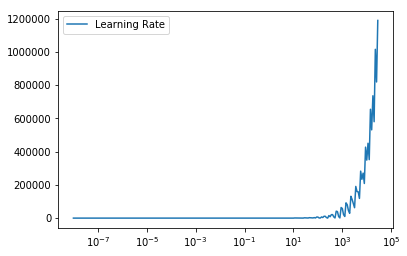

In [0]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

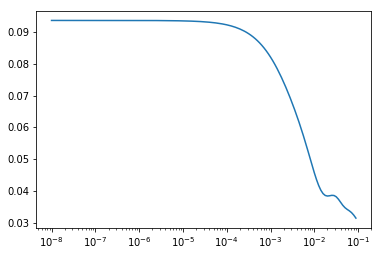

In [0]:
plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])

It looks like the learning rate of 0.1 seems to work the best.  Let's use that learning rate and train the network this time for real.  Once we train the network, let's predict the prices for the training and test data.

In [0]:
# Observing the above graph, 0.1 seems to be the best learning rate
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])


optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))

Train on 174 samples, validate on 44 samples
Epoch 1/250
174/174 [==============================] - 2s 13ms/step - loss: 0.0839 - mean_absolute_error: 0.3495 - val_loss: 0.0606 - val_mean_absolute_error: 0.2919
Epoch 2/250
174/174 [==============================] - 0s 1ms/step - loss: 0.0665 - mean_absolute_error: 0.2970 - val_loss: 0.0805 - val_mean_absolute_error: 0.3583
Epoch 3/250
174/174 [==============================] - 0s 1ms/step - loss: 0.0545 - mean_absolute_error: 0.2560 - val_loss: 0.0747 - val_mean_absolute_error: 0.3430
Epoch 4/250
174/174 [==============================] - 0s 1ms/step - loss: 0.0453 - mean_absolute_error: 0.2353 - val_loss: 0.0429 - val_mean_absolute_error: 0.2248
Epoch 5/250
174/174 [==============================] - 0s 1ms/step - loss: 0.0351 - mean_absolute_error: 0.2183 - val_loss: 0.0260 - val_mean_absolute_error: 0.1787
Epoch 6/250
174/174 [==============================] - 0s 1ms/step - loss: 0.0396 - mean_absolute_error: 0.2211 - val_loss: 0.028

Once we predict the values, we also must *reverse* the normalization so that we can plot the predictions in the same scale as the original values.

In [0]:
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

Let's now plot what the training and test predictions look like and compare witht he original values.

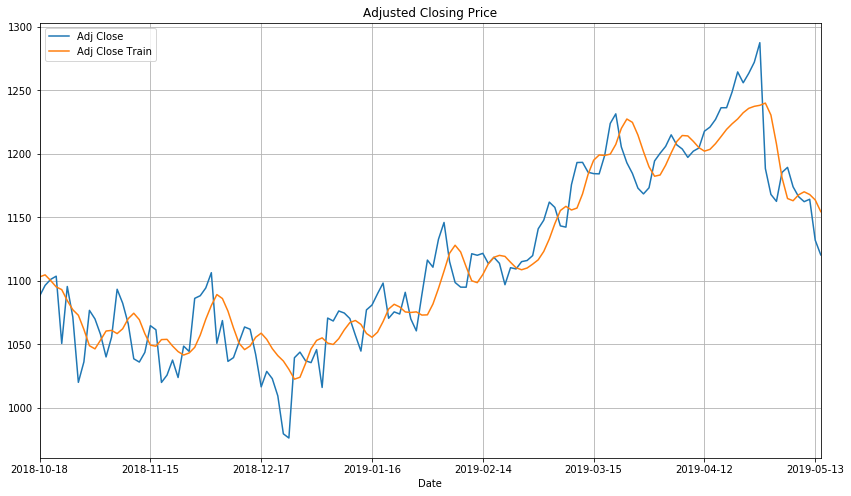

In [0]:
# Plot what it looks like for the training data
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]
df_keras.plot(label='GOOG', figsize=(14,8), title='Adjusted Closing Price', grid=True)

Again, quite accurate... and now for the test data.



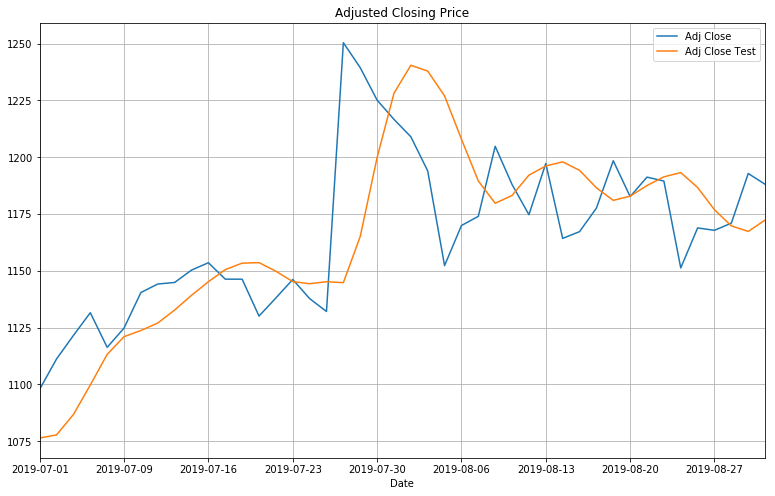

In [0]:
# Same for the test
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_keras['Adj Close Test'] = y_pred_keras
df_keras.plot(label='GOOG', figsize=(13,8), title='Adjusted Closing Price', grid=True)

I have more confidence in the neural network approach as it seems to indicate would the trend would be like when the data is noise free.  We can also see a more smoother transition between points of high curvature.

Finally to see how everything performs, let's plot all of the methods together for both the training and testing data.

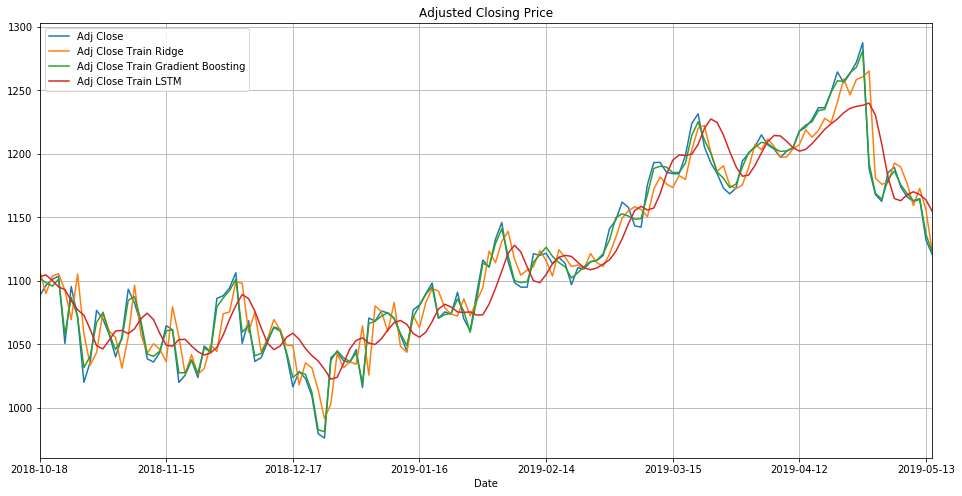

In [0]:
df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] # Past 32 days we don't know yet
# Add in all of our methods
df_train['Adj Close Train Ridge'] = y_pred_train_ridge[:-window_size]
df_train['Adj Close Train Gradient Boosting'] = y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-window_size]
# Plot the data now
df_train.plot(label='GOOG', figsize=(16,8), title='Adjusted Closing Price', grid=True)


Cool.  They all more or less follow the same trend... and now for the testing data.

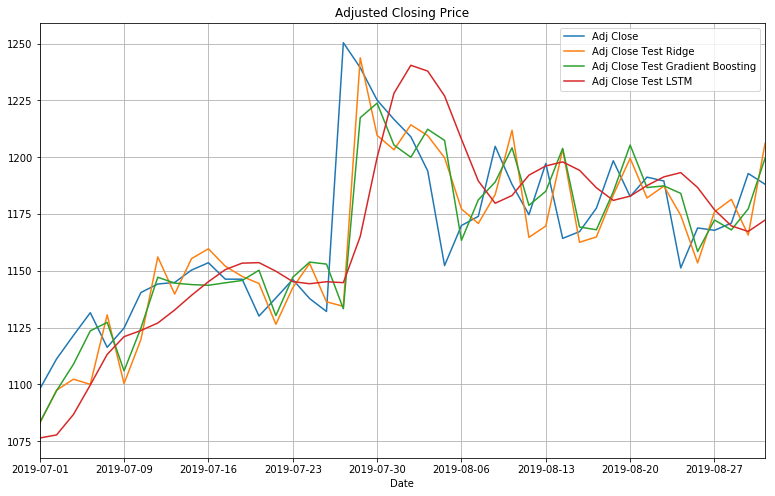

In [0]:
df_test = df.copy()
df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[ind_split+window_size:] # Past 32 days we don't know yet
# Add in all of our methods
df_test['Adj Close Test Ridge'] = y_pred_ridge
df_test['Adj Close Test Gradient Boosting'] = y_pred_gb
df_test['Adj Close Test LSTM'] = y_pred_keras
# Plot the data now
df_test.plot(label='GOOG', figsize=(13,8), title='Adjusted Closing Price', grid=True)


So here's where it gets interesting.  We can see that the neural network based method is what the values would be when there's no presence of noise.  The ridge regression based method seems to follow the trend the best with the noise modelled in.  The gradient boosting method also follows the same trend, but because the method does not use interpolation, points of very high curvature tend to be the most inaccurate.

# So what happens if we don't have testing data to try out?

Good question.  What you can do take the learned model that you have, then start with the last $N$ values in your data (in my case 32), and start predicting what the next values will be.  With the next values, keep using the previous $N$ values for your desired forecasting.

We already have our learned models above, so let's go ahead and do that.

In [0]:
num_days = 10 # Let's try and forecase the next 10 days or two years

# Get the last window_size (32) days
data_seed = df['Adj Close'].values[-window_size:][None]
# Get the normalized data as well for the neural network
data_seed_norm = scaler.transform(data_seed)
input_values = {"ridge": data_seed, "gb": data_seed, "keras": data_seed_norm.copy()}
values = {"ridge": [], "gb": [], "keras": []}
for i in range(num_days): # For each day...
    # Predict the next price given the previous N prices
    values["ridge"].append(ridge_model.predict(input_values["ridge"])[0])
    values["gb"].append(gb_model.predict(input_values["gb"])[0])
    values["keras"].append(keras_model.predict(input_values["keras"][...,None])[0][0])

    # Dump the oldest price and put the newest price at the end
    for v in input_values:
        val = input_values[v]
        val = np.insert(val, -1, values[v][-1], axis=1)
        val = np.delete(val, 0, axis=1)
        input_values[v] = val.copy()

# Convert all to NumPy arrays
for v in input_values:
    values[v] = np.array(values[v])

# Unnormalize prices from NN approach
values["keras"] = scaler.inverse_transform(values["keras"][None])[0]
    

Now let's plot the next 10 days worth of data

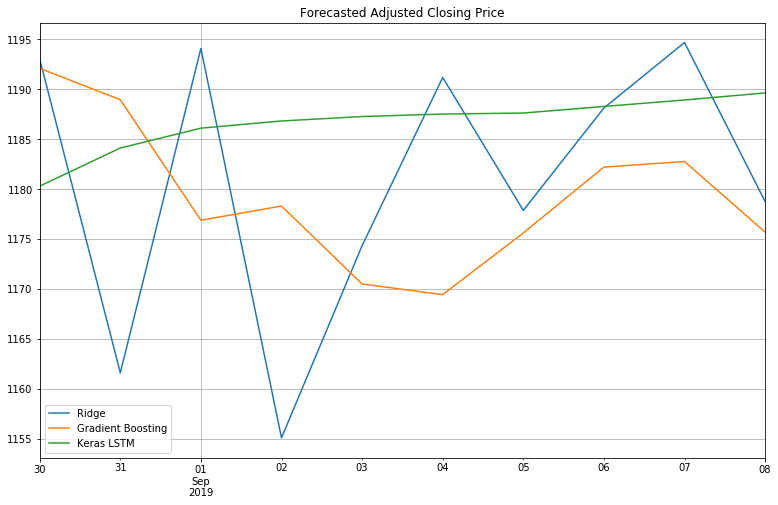

In [0]:
from datetime import timedelta, datetime
last_date = datetime.strptime(df.index[-1], '%Y-%m-%d')
df_forecast = pd.DataFrame()
df_forecast["Ridge"] = values["ridge"]
df_forecast["Gradient Boosting"] = values["gb"]
df_forecast["Keras LSTM"] = values["keras"]
df_forecast.index = pd.date_range(start=last_date, periods=num_days)
df_forecast.plot(label='GOOG', figsize=(13,8), title='Forecasted Adjusted Closing Price', grid=True)